In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
active_directory = '/content/drive/MyDrive/Desktop/DP_Finetuning_Harnet_Submission'
os.chdir(active_directory)

Mounted at /content/drive


## IMPORT LIBRARIES

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import pickle
from warnings import filterwarnings
from pandas.errors import SettingWithCopyWarning
import copy

filterwarnings("ignore", category=SettingWithCopyWarning)
filterwarnings('ignore', category=UserWarning)

## READ SUBJECT FILES

Each of the data-files contains 54 columns per row, the columns contain the following data:

-  1 timestamp (s)
- 2 activityID (see II.2. for the mapping to the activities)
- 3 heart rate (bpm)
- 4-20 IMU hand
- 21-37 IMU chest
- 38-54 IMU ankle

The IMU sensory data contains the following columns:

- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
-  5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

16g acceleration hand -> indexes [4, 5, 6]

timestamp -> [0]

activity_id -> [1]

In [ ]:
def read_subject_file(file_path:str)->pd.DataFrame:
    subject_name = file_path.split('/')[-1].rstrip('.dat')
    subject = pd.read_table(file_path, header=None, sep='\s+')
    return subject, subject_name

class DataProcessor:
  def __init__(self, subject_dataframe:pd.DataFrame, subject_name:str):
    self.subject_dataframe = subject_dataframe
    self.subject_name = subject_name
    self.acc_x_col = 'acc_x'
    self.acc_y_col = 'acc_y'
    self.acc_z_col = 'acc_z'
    self.timestamp = 'timestamp'
    self.activity_id = 'activity_id'

  def _extract_data(self)->pd.DataFrame:
    """
    Extract the relevant columns from the data
    """
    # timestamp, activity_id, 16g_acc_x, 16g_acc_y, 16g_acc_z
    raw_data = self.subject_dataframe.iloc[:, [0, 1, 4, 5, 6]]
    raw_data.columns = [self.timestamp , self.activity_id , self.acc_x_col, self.acc_y_col, self.acc_z_col]
    return raw_data

  def _handle_missing_values(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Used linear interpolation for the acceleration data
    """
    data[self.acc_x_col] = data[self.acc_x_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_y_col] = data[self.acc_y_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_z_col] = data[self.acc_z_col].interpolate(method='linear', limit_direction='both')
    return data

  def sorted_timestamps(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Sort the timestamps in ascending order
    """
    data = data.sort_values(by=self.timestamp, ascending=True).reset_index(drop=True)
    return data


  def downsample_from_100_to_30hz(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Downsample the data from 100Hz to 30Hz
    """

    data_copy = data.copy()
    data_copy.set_index(self.timestamp, inplace=True)
    data_copy.index = pd.to_timedelta(data_copy.index, unit="s")
    data_copy = data_copy.resample('0.0333s').agg({self.activity_id: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
                                        self.acc_x_col:"mean",
                                        self.acc_y_col:"mean",
                                        self.acc_z_col:"mean"}).reset_index()
    return data_copy


def activity_mapping(value:int):
  mapping_dict = {
        0: "other",
        1: "lying",
        2: "sitting",
        3: "standing",
        4: "walking",
        5: "running",
        6: "cycling",
        7: "Nordic walking",
        9: "watching TV",
        10: "computer work",
        11: "car driving",
        12: "ascending stairs",
        13: "descending stairs",
        16: "vacuum cleaning",
        17: "ironing",
        18: "folding laundry",
        19: "house cleaning",
        20: "playing soccer",
        24: "rope jumping"
   }
  return mapping_dict.get(value, 'Unknown')


def create_sliding_windows(dataframe, window_length_sec, sampling_rate_hz, step_duration_sec):
  import scipy.stats as stats


  N_FEATURES = 3
  window_length_samples = int(window_length_sec * sampling_rate_hz)
  step_duration_samples = int(step_duration_sec * sampling_rate_hz)
  windows = []
  labels = []
  for i in range(0, len(dataframe)-window_length_samples, step_duration_samples):
    x = dataframe['acc_x'].values[i: i + window_length_samples]
    y = dataframe['acc_y'].values[i: i + window_length_samples]
    z = dataframe['acc_z'].values[i: i + window_length_samples]
    window = np.array([x, y, z])
    label = dataframe['activity_id'][i: i + window_length_samples]

    windows.append(window)
    labels.append(label)

  windows = np.asarray(windows).reshape(-1, N_FEATURES, window_length_samples, )
  labels = np.asarray(labels)

  return windows, labels



def clean_window_labels(window_X, window_y):
  """
  Remove the windows that have activity id = 0 ratio > 0.5
  """
  clean_window_X = []
  clean_window_y = []

  for i in range(len(window_y)):
    if np.sum(window_y[i] == 0) / len(window_y[i]) < 0.5:
      clean_window_X.append(window_X[i])
      clean_window_y.append(window_y[i])

  clean_window_X = np.array(clean_window_X)
  clean_window_y = np.array(clean_window_y)

  return clean_window_X, clean_window_y


def majority_voting(window_y):
  """
  Most frequent activity id in a window
  """
  from scipy import stats as st

  major_window_y = st.mode(window_y, axis=1).mode
  return major_window_y


def reshaped_windows(window_X, window_y):
  """
  Reshape the windows to fit the model (n_windows, n_features, n_timestamps)
  """
  window_X = window_X.reshape(window_X.shape[0], window_X.shape[2], window_X.shape[1])
  window_y = window_y.reshape(window_y.shape[0], )
  return window_X, window_y


def activity_filter(window_X, window_y):
  """
  Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)
  """
  filtered_window_X = []
  filtered_window_y = []

  valid_indices = (
            (window_y == 1) | (window_y == 2) | (window_y == 3) | (window_y == 4) | (window_y == 12) | (window_y == 13) | (window_y == 16) | (window_y == 17)
        )

  filtered_window_X = window_X[valid_indices]
  filtered_window_y = window_y[valid_indices]

  return filtered_window_X, filtered_window_y



In [ ]:
file_dir = 'Protocol'
subject_raw_files = os.listdir(file_dir)

In [ ]:
subject_arr_Xs = []
subject_arr_ys = []
subject_names = []

window_length_sec = 10
step_duration_sec = 5
sampling_rate_hz = 30
overlap_ratio = round((100*(window_length_sec-step_duration_sec)/window_length_sec), 2)


print(f'WINDOW LENGTH in SAMPLES: {int(window_length_sec * sampling_rate_hz)}')
print(f'STEP DURATION in SAMPLES: {int(step_duration_sec * sampling_rate_hz)}')
print(f'OVERLAPPING WINDOW RATIO: {overlap_ratio}%')


for f in subject_raw_files:
  file_path = os.path.join(file_dir, f)
  subject, subject_name = read_subject_file(file_path)
  if subject_name != 'subject109':
    print('-----------------------------------------------------------')
    print(f'Data preprocessing is starting for {subject_name}...')
    processor = DataProcessor(subject, subject_name)
    raw_data = processor._extract_data()

    subject_df = processor._handle_missing_values(raw_data)   # Missing axes values are filled by applying linear interpolation
    subject_df = processor.sorted_timestamps(subject_df)    # Update if the timestamps is not ascending
    downsampled_subject_df = processor.downsample_from_100_to_30hz(subject_df)    # Downsample the data from 100Hz to 30Hz

    win_X, win_y = create_sliding_windows(downsampled_subject_df, window_length_sec=window_length_sec, sampling_rate_hz=sampling_rate_hz, step_duration_sec=step_duration_sec)
    clean_win_X, clean_win_y = clean_window_labels(win_X, win_y)    # Remove the windows that have activity id = 0 ratio > 0.5
    major_win_y = majority_voting(clean_win_y)    # Majority voting for the labels in a window
    filtered_window_X, filtered_window_y = activity_filter(clean_win_X, major_win_y)   # Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)

    print(f'Final remaining shapes X: {filtered_window_X.shape}, y: {filtered_window_y.shape}')

    subject_arr_Xs.append(filtered_window_X)
    subject_arr_ys.append(filtered_window_y)
    subject_names.append(subject_name)


all_subject_infos = list(zip(subject_names, subject_arr_Xs, subject_arr_ys))

WINDOW LENGTH in SAMPLES: 300
STEP DURATION in SAMPLES: 150
OVERLAPPING WINDOW RATIO: 50.0%
-----------------------------------------------------------
Data preprocessing is starting for subject101...
Final remaining shapes X: (345, 3, 300), y: (345,)
-----------------------------------------------------------
Data preprocessing is starting for subject102...
Final remaining shapes X: (373, 3, 300), y: (373,)
-----------------------------------------------------------
Data preprocessing is starting for subject103...
Final remaining shapes X: (348, 3, 300), y: (348,)
-----------------------------------------------------------
Data preprocessing is starting for subject104...
Final remaining shapes X: (364, 3, 300), y: (364,)
-----------------------------------------------------------
Data preprocessing is starting for subject105...
Final remaining shapes X: (379, 3, 300), y: (379,)
-----------------------------------------------------------
Data preprocessing is starting for subject106...

In [3]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def get_pretrained_harnet(class_num, model_name = 'harnet10'):
    repo = 'OxWearables/ssl-wearables'
    model = torch.hub.load(repo, model_name, class_num=class_num, pretrained=True, force_reload=True)
    return model

def train(model, train_loader, optimizer, criterion, epoch, device, is_dp=False, privacy_engine=None, delta=None):
  model.train()
  total_loss = 0
  correct = 0
  total_samples = 0
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * data.size(0)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size(0)
      if batch_idx % 10 == 0:
          if is_dp and privacy_engine:
              epsilon = privacy_engine.get_epsilon(delta)
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}\tEpsilon: {epsilon:.2f}")
          else:
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}")

  avg_loss = total_loss / total_samples
  accuracy = 100. * correct / total_samples
  print(f"Epoch {epoch} - Training: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
  return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  correct = 0
  all_preds = []
  all_targets = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item() * data.size(0)
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
          all_preds.extend(pred.cpu().numpy())
          all_targets.extend(target.cpu().numpy())
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
  print(f"Evaluation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({accuracy:.2f}%), F1-score: {f1:.4f}\n")
  return test_loss, accuracy, f1

def predict(model, data_loader, device):
  model.eval()
  all_preds = []
  with torch.no_grad():
      for data, _ in data_loader:
          data = data.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          all_preds.extend(pred.cpu().numpy())
  return all_preds

def predict_proba(model, data_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            output = model(data)
            # Apply softmax to get probabilities
            probs = torch.softmax(output, dim=1)
            all_probs.extend(probs.cpu().numpy())
    return all_probs

class CustomScaler:
  """
  A wrapper for scikit-learn's StandardScaler that handles both 2D and 3D NumPy arrays.
  For 3D data, it reshapes to 2D, scales, and then reshapes back.
  """
  def __init__(self):
      self._scaler = StandardScaler()
      self._is_fitted = False
      self._original_input_dims = None
  def fit(self, data: np.ndarray):
      self._original_input_dims = data.ndim
      if self._original_input_dims == 2:
          self._scaler.fit(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          self._scaler.fit(reshaped_data)
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")
      self._is_fitted = True
      return self
  def fit_transform(self, data: np.ndarray) -> np.ndarray:
      self._original_input_dims = data.ndim

      if self._original_input_dims == 2:
          scaled_data = self._scaler.fit_transform(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          # Reshape 3D data to 2D for scaling
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          scaled_reshaped_data = self._scaler.fit_transform(reshaped_data)
          # Reshape scaled data back to original 3D shape
          scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")

      self._is_fitted = True
      return scaled_data

  def transform(self, data: np.ndarray) -> np.ndarray:
    if not self._is_fitted:
      raise RuntimeError("Scaler has not been fitted. Call fit_transform first.")
    if data.ndim != self._original_input_dims:
      raise ValueError(f"Input data has {data.ndim} dimensions, but scaler was fitted on "
                            f"data with {self._original_input_dims} dimensions.")
    if self._original_input_dims == 2:
        scaled_data = self._scaler.transform(data)
    elif self._original_input_dims == 3:
        n_samples, n_timesteps, n_features = data.shape
        reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
        scaled_reshaped_data = self._scaler.transform(reshaped_data)
        scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
    else:
        raise ValueError("Input data must have 2 or 3 dimensions.")

    return scaled_data

def get_data_loader(X_test, y_test, BATCH_SIZE, shuffle=False):
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle)
  return test_loader

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False):
      self.patience = patience
      self.delta = delta
      self.best_score = None
      self.early_stop = False
      self.counter = 0
      self.best_model_state = None
      self.verbose = verbose
      self.best_epoch = 0
  def __call__(self, val_loss, model, epoch):
      score = -val_loss
      if self.best_score is None:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
      elif score < self.best_score + self.delta:
          self.counter += 1
          if self.verbose:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
          if self.counter >= self.patience:
              self.early_stop = True
      else:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
          self.counter = 0

  def load_best_model(self, model):
      if self.best_model_state:
          model.load_state_dict(self.best_model_state)



def plot_distribution(arr:np.ndarray, title:str):
  pd.Series(arr).value_counts(normalize=True).plot(kind='bar')
  plt.title(title)
  plt.show()


In [ ]:
def fold_plot(fold_train_accuracies, fold_val_accuracies, val_subjects):
  import matplotlib.pyplot as plt
  import math
  # Get the list of train and val accuracies
  acc_list_zipped = list(zip(fold_train_accuracies, fold_val_accuracies, val_subjects))

  # Get the total number of folds to plot
  num_folds = len(acc_list_zipped)

  # --- Subplot Layout Calculation ---
  ncols = 2
  nrows = math.ceil(num_folds / ncols)

  # --- Create the Figure and Subplots ---
  fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))
  fig.suptitle('Training vs. Validation Accuracy Across Folds', fontsize=16, y=1.02)
  axes = axes.flatten()


  # --- Loop and Plot on Each Subplot ---
  for i, (tr_acc, vl_acc, vl_subjects) in enumerate(acc_list_zipped):
      ax = axes[i] # Get the current axis
      ax.plot(tr_acc, label='Train Accuracy', color='royalblue')
      ax.plot(vl_acc, label='Validation Accuracy', color='darkorange')
      ax.set_title(f'Fold: {i + 1} for  Validation Subjects {vl_subjects}')
      ax.set_xlabel('Epoch')
      ax.set_ylabel('Accuracy')
      ax.legend()
      ax.grid(True, linestyle='--', alpha=0.6)

  # --- Clean Up and Display ---
  # If the number of folds is odd, the last subplot in the grid will be empty.
  # This loop hides any unused subplots.
  for i in range(num_folds, len(axes)):
      axes[i].axis('off')

  # Adjusts subplot params so that subplots are nicely fit in the figure.
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  return fig


def plot_epochs(train_accs, val_accs, val_subj):
  import matplotlib.pyplot as plt
  epochs = np.arange(1, len(train_accs) + 1)
  fig, ax = plt.subplots()
  ax.plot(epochs, train_accs, label='Train Accuracy', color='royalblue')
  ax.plot(epochs, val_accs, label='Validation Accuracy', color='darkorange')
  ax.set_title(f'Training vs. Validation Accuracy for Validation Subjects {val_subj}')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_xticks(epochs)
  ax.legend()
  ax.grid(True, linestyle='--', alpha=0.6)
  return fig


def plot_roc_curve(y_score, y_true, noise_scale=None):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_score=y_score, y_true=y_true)

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", linewidth=2,
             label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linewidth=2,
             linestyle="--", label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    if noise_scale:
        plt.title(f"Attack Model ROC Curve for DP Classifier Head Fine-Tuned Model (σ = {noise_scale})")
    else:
        plt.title("Attack Model ROC Curve for Non-Private Baseline")

    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Optionally return the AUC score
    return auc_score


def remove_module_prefix(state_dict):
    return {k.replace("_module.", ""): v for k, v in state_dict.items()}


## SPLITTING DATASETS INTO TARGET AND SHADOW MODELS

In [ ]:
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, LeaveOneGroupOut
import torch.nn as nn
import copy
from itertools import product

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

reports_save = False

label_encoder = LabelEncoder()

Target_Model_X = []
Target_Model_y = []
Target_Model_subject_groups = []

Shadow_Model_X = []
Shadow_Model_y = []
Shadow_Model_subject_groups = []
Shadow_Model_subject_names = []


for sb_name, Xs, ys in all_subject_infos:
  if sb_name not in ['subject102','subject103']:           # Test subject for membership inference attack as a non-member
    Target_Model_X.extend(Xs)
    Target_Model_y.extend(ys)
    Target_Model_subject_groups.extend([sb_name] * len(ys))
  else:
    Shadow_Model_subject_names.append(sb_name)
    Shadow_Model_X.extend(Xs)
    Shadow_Model_y.extend(ys)
    Shadow_Model_subject_groups.extend([sb_name] * len(ys))


Target_Model_X = np.array(Target_Model_X)
Target_Model_y = np.array(Target_Model_y)
Target_Model_subject_groups = np.array(Target_Model_subject_groups)

Shadow_Model_X = np.array(Shadow_Model_X)
Shadow_Model_y = np.array(Shadow_Model_y)
Shadow_Model_subject_groups = np.array(Shadow_Model_subject_groups)

print(f'Target Model X shape: {Target_Model_X.shape}, y shape: {Target_Model_y.shape}, Subjects : {", ".join(np.unique(Target_Model_subject_groups))}')
print(f'Shadow Model X shape: {Shadow_Model_X.shape}, y shape: {Shadow_Model_y.shape}, Subjects : {", ".join(np.unique(Shadow_Model_subject_groups))}')


Target Model X shape: (2166, 3, 300), y shape: (2166,), Subjects : subject101, subject104, subject105, subject106, subject107, subject108
Shadow Model X shape: (721, 3, 300), y shape: (721,), Subjects : subject102, subject103


### Training Shadow Models

They will be the exact same architecture with the target model. They will have the exact same fine-tuning procedure. The idea is to mimic the Target Model training data. So we can take a pair of subsets from the Shadow Model data that represents the data distribution. We need to split it subject-wise. Take Subject102 as shadow training, Subject103 as shadow test

In [ ]:
shadow_le = LabelEncoder()
shadow_le.fit(Shadow_Model_y)

N_CLASSES = len(shadow_le.classes_)
LRATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded


In [ ]:
from sklearn.model_selection import train_test_split

subject102_indices = np.where(Shadow_Model_subject_groups == 'subject102')[0]
subject103_indices = np.where(Shadow_Model_subject_groups == 'subject103')[0]

# Split data into S_train (members) and S_test (non-members) -> We will use subject102 as S_train and subject103 as S_test
S_train_X, S_train_y = Shadow_Model_X[subject102_indices], Shadow_Model_y[subject102_indices]
S_test_X, S_test_y = Shadow_Model_X[subject103_indices], Shadow_Model_y[subject103_indices]


# Collect the subsets and predictions
shadow_model_names = []
train_subsets = []
train_predictions = []
test_predictions = []


shadow_info = {
    'shadow_model_names': [],
    'train_subset_indices': [],
    'best_val_loss':[],
    'best_val_acc':[],
    'best_val_f1':[],
    'best_epoch':[],
    'best_train_acc':[],
    'best_train_loss':[],

    'test_loss': [],
    'test_acc': [],
    'test_f1': [],

    'train_val_preds':[],
    'test_preds':[]
}
# Take k random subset from training set for shadow models training
k = 5
n_rows =int(S_train_X.shape[0] * 0.8)
test_ratio=0.2
np.random.seed(42)
for i in range(1, k+1):
  print('#' * 20)
  print(f'Shadow Model {i} is on the scene :)')
  print('-' * 20)
  shadow_info['shadow_model_names'].append(f'shadow_model_{i}')

  subset_indices = np.random.choice(S_train_X.shape[0], size=n_rows, replace=False)
  S_t_X_subset, S_t_y_subset = S_train_X[subset_indices], S_train_y[subset_indices]
  S_train_X_subset, S_val_X_subset, S_train_y_subset, S_val_y_subset = train_test_split(S_t_X_subset, S_t_y_subset, test_size=test_ratio, stratify=S_t_y_subset)

  shadow_info['train_subset_indices'].append(subset_indices)

  cs_scaler = CustomScaler()
  scaled_S_train_X_subset = cs_scaler.fit_transform(S_train_X_subset)
  scaled_S_val_X_subset = cs_scaler.transform(S_val_X_subset)

  scaled_S_test_X = cs_scaler.transform(S_test_X)

  encoded_S_train_y_subset = shadow_le.transform(S_train_y_subset)
  encoded_S_val_y_subset = shadow_le.transform(S_val_y_subset)

  encoded_S_test_y = shadow_le.transform(S_test_y)

  train_data_loader = get_data_loader(scaled_S_train_X_subset, encoded_S_train_y_subset, BATCH_SIZE=BATCH_SIZE, shuffle=True)
  val_data_loader = get_data_loader(scaled_S_val_X_subset, encoded_S_val_y_subset, BATCH_SIZE=BATCH_SIZE, shuffle=False)

  test_data_loader = get_data_loader(scaled_S_test_X, encoded_S_test_y, BATCH_SIZE=BATCH_SIZE, shuffle=False)

  model = copy.deepcopy(original_model)
  model.to(device)
  for name, param in model.named_parameters():
    if name.startswith('classifier'):
      param.requires_grad = True
    else:
      param.requires_grad = False

  optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LRATE, weight_decay=0.01)
  criterion = nn.CrossEntropyLoss()
  early_stopping = EarlyStopping(patience=10, verbose=True)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

  best_val_loss = float('inf')

  for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, epoch, device)
    val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, criterion, device)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      final_best_model = copy.deepcopy(model.state_dict())
      final_best_val_acc = val_acc
      final_best_val_f1 = val_f1
      final_best_epoch = epoch
      final_best_train_acc = train_acc
      final_best_train_loss = train_loss


    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
      print("Early stopping")
      break

  shadow_info['best_val_loss'].append(best_val_loss)
  shadow_info['best_val_acc'].append(final_best_val_acc)
  shadow_info['best_val_f1'].append(final_best_val_f1)
  shadow_info['best_epoch'].append(final_best_epoch)
  shadow_info['best_train_acc'].append(final_best_train_acc)
  shadow_info['best_train_loss'].append(final_best_train_loss)

  final_best_model_sh = copy.deepcopy(original_model)
  final_best_model_sh.load_state_dict(remove_module_prefix(final_best_model))
  final_best_model_sh.to(device)

  train_preds =  predict_proba(final_best_model_sh, train_data_loader, device)
  val_preds =  predict_proba(final_best_model_sh, val_data_loader, device)
  test_preds =  predict_proba(final_best_model_sh, test_data_loader, device)
  train_val_preds = train_preds + val_preds

  test_loss, test_acc, test_f1 = evaluate(final_best_model_sh, test_data_loader, criterion, device)

  shadow_info['train_val_preds'].append(train_val_preds)
  shadow_info['test_preds'].append(test_preds)
  shadow_info['test_loss'].append(test_loss)
  shadow_info['test_acc'].append(test_acc)
  shadow_info['test_f1'].append(test_f1)

  print(f'***** Test Loss : {test_loss}, Test Acc : {test_acc}, Test F1 : {test_f1} *****')


attack_report_save = True
today_date = dt.date.today().strftime("%Y%m%d")
attack_save_directory = 'attack_results_DP'
if attack_report_save:
  os.makedirs(attack_save_directory, exist_ok=True)
  shadow_report_name = f'shadow_report_{today_date}.xlsx'
  shadow_report_df = pd.DataFrame(shadow_info)
  shadow_report_df.to_excel(os.path.join(attack_save_directory, shadow_report_name))



####################
Shadow Model 1 is on the scene :)
--------------------
Train Epoch: 1 [0/238 (0%)]	Loss: 8.232292
Epoch 1 - Training: Average loss: 4.7456, Accuracy: 43.28%
Evaluation set: Average loss: 2.8144, Accuracy: 28/60 (46.67%), F1-score: 0.3739

Train Epoch: 2 [0/238 (0%)]	Loss: 1.918775
Epoch 2 - Training: Average loss: 1.7280, Accuracy: 78.57%
Evaluation set: Average loss: 1.7928, Accuracy: 41/60 (68.33%), F1-score: 0.6712

Train Epoch: 3 [0/238 (0%)]	Loss: 1.180454
Epoch 3 - Training: Average loss: 1.2675, Accuracy: 77.73%
Evaluation set: Average loss: 1.3073, Accuracy: 47/60 (78.33%), F1-score: 0.7561

Train Epoch: 4 [0/238 (0%)]	Loss: 0.750557
Epoch 4 - Training: Average loss: 0.9469, Accuracy: 84.03%
Evaluation set: Average loss: 1.6767, Accuracy: 46/60 (76.67%), F1-score: 0.7416

EarlyStopping counter: 1 out of 10
Train Epoch: 5 [0/238 (0%)]	Loss: 0.484076
Epoch 5 - Training: Average loss: 0.5475, Accuracy: 86.97%
Evaluation set: Average loss: 1.3234, Accuracy: 47/

### Preparing & Saving Attack Model Dataset

In [ ]:
train_preds_collected = []
test_preds_collected = []


for i in range(len(shadow_report_df)):
  train_preds_collected.extend(shadow_report_df["train_val_preds"][i])
  test_preds_collected.extend(shadow_report_df["test_preds"][i])

train_preds_collected = np.array(train_preds_collected)
test_preds_collected = np.array(test_preds_collected)

members_label = np.ones((train_preds_collected.shape[0],))        # Member = 1
non_members_label = np.zeros((test_preds_collected.shape[0],))        # Non-member = 0

attack_features = np.concatenate([train_preds_collected, test_preds_collected])
attack_labels = np.concatenate([members_label, non_members_label]).reshape(-1, 1)

attack_df = pd.DataFrame(np.concatenate([attack_features, attack_labels], axis=1))

if attack_report_save:
  attack_save_directory = 'attack_results_DP'
  os.makedirs(attack_save_directory, exist_ok=True)
  attack_df_name = f'attack_df_{today_date}.xlsx'
  attack_df.to_excel(os.path.join(attack_save_directory, attack_df_name))


In [ ]:

if attack_report_save:
  read_attack_df = pd.read_excel(os.path.join(attack_save_directory, attack_df_name))
  read_attack_df = read_attack_df.drop(columns=['Unnamed: 0'])
  print(f'{attack_df_name} is read.')

else:
  existing_attack_df_name = 'attack_df_20250625.xlsx'
  read_attack_df = pd.read_excel(os.path.join(attack_save_directory, existing_attack_df_name))
  read_attack_df = read_attack_df.drop(columns=['Unnamed: 0'])
  print(f'{existing_attack_df_name} is read.')

attack_df_20250630.xlsx is read.


## Train Attack Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

attack_model_save = False

X = read_attack_df.iloc[:, :-1].values
y = read_attack_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)

# 8. Initialize XGBoost classifier
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    learning_rate=1e-1,
    n_estimators=200,
    max_depth=6,
    early_stopping_rounds=10,
    random_state=42
)

# 9. Train with early stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# 10. Predictions & evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]  # for binary AUC

print("Test Accuracy:  ", accuracy_score(y_test, y_pred))
print("Test ROC AUC:   ", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


if attack_model_save:
  attack_model_name = f'attack_model_{today_date}.json'
  attack_model_path = os.path.join(attack_save_directory, attack_model_name)

  clf.save_model(attack_model_path)

[0]	validation_0-auc:0.76483
[1]	validation_0-auc:0.77415
[2]	validation_0-auc:0.78692
[3]	validation_0-auc:0.79382
[4]	validation_0-auc:0.80125
[5]	validation_0-auc:0.80604
[6]	validation_0-auc:0.80712
[7]	validation_0-auc:0.81210
[8]	validation_0-auc:0.81362
[9]	validation_0-auc:0.81835
[10]	validation_0-auc:0.81899
[11]	validation_0-auc:0.82178
[12]	validation_0-auc:0.82328
[13]	validation_0-auc:0.82220
[14]	validation_0-auc:0.82424
[15]	validation_0-auc:0.82478
[16]	validation_0-auc:0.82813
[17]	validation_0-auc:0.82989
[18]	validation_0-auc:0.83315
[19]	validation_0-auc:0.83598
[20]	validation_0-auc:0.83702
[21]	validation_0-auc:0.83805
[22]	validation_0-auc:0.84100
[23]	validation_0-auc:0.84294
[24]	validation_0-auc:0.84327
[25]	validation_0-auc:0.84440
[26]	validation_0-auc:0.84520
[27]	validation_0-auc:0.84395
[28]	validation_0-auc:0.84620
[29]	validation_0-auc:0.84686
[30]	validation_0-auc:0.84690
[31]	validation_0-auc:0.84746
[32]	validation_0-auc:0.84773
[33]	validation_0-au

## Executing the Attack Model On Our DP-SGD and Non-Private Baseline

In [ ]:
# Call pre-trained model
final_dp_model_path = 'attack_results_DP/final_models/final_model_1_10_30_50.0_20250625.pth'
final_dp_scaler_path = 'attack_results_DP/final_models/final_scaler_1_10_30_50.0_20250625.pkl'
final_dp_label_encoder_path = 'attack_results_DP/final_models/final_label_encoder_1_10_30_50.0_20250625.pkl'

BATCH_SIZE = 32

final_scaler_dp = pickle.load(open(final_dp_scaler_path, 'rb'))
final_le_dp = pickle.load(open(final_dp_label_encoder_path, 'rb'))

N_CLASSES = len(final_le_dp.classes_)

In [ ]:
original_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded


In [ ]:
# Loading the Attack Model
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb

if attack_model_save:
  attack_model_name = f'attack_model_{today_date}.json'
  attack_model_path = os.path.join(attack_save_directory, attack_model_name)
  clf = xgb.XGBClassifier()
  clf.load_model(attack_model_path)
else:
  attack_model_path = 'attack_results_DP/attack_model_20250625.json'
  clf = xgb.XGBClassifier()
  clf.load_model(attack_model_path)

In [ ]:
# Evaluation of the Attack Model

from sklearn.model_selection import train_test_split

if attack_report_save:
  attack_save_directory = 'attack_results_DP'
  attack_df_name = f'attack_df_{today_date}.xlsx'
else:
  attack_save_directory = 'attack_results_DP'
  attack_df_name = f'attack_df_20250625.xlsx'

read_attack_df = pd.read_excel(os.path.join(attack_save_directory, attack_df_name))
read_attack_df = read_attack_df.drop(columns=['Unnamed: 0'])

X = read_attack_df.iloc[:, :-1].values
y = read_attack_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)


# 10. Predictions & evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]  # for binary AUC

print("Test Accuracy:  ", accuracy_score(y_test, y_pred))
print("Test ROC AUC:   ", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy:   0.7275541795665634
Test ROC AUC:    0.7987348607575407

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75       348
           1       0.71      0.68      0.70       298

    accuracy                           0.73       646
   macro avg       0.73      0.72      0.72       646
weighted avg       0.73      0.73      0.73       646



In [ ]:
def plot_roc_curve_v2(y_score, y_true, title=None):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_score=y_score, y_true=y_true)

    # Calculate AUC score
    auc_score = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", linewidth=2,
             label=f"ROC curve (AUC = {auc_score:.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linewidth=2,
             linestyle="--", label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    if title:
        plt.title(title)

    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Optionally return the AUC score
    return auc_score




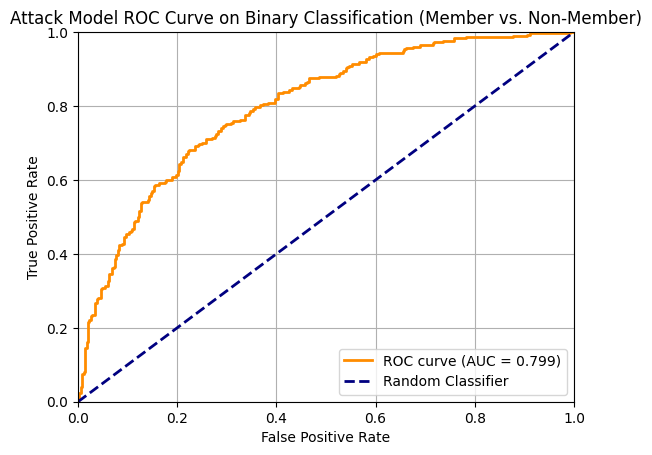

In [ ]:
fig1 = plot_roc_curve_v2(y_prob, y_test, title='Attack Model ROC Curve on Binary Classification (Member vs. Non-Member)')


In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

def plot_confusion_heatmap_binary(
    df: pd.DataFrame,
    true_col: str = 'True',
    pred_col: str = 'Preds',
    normalize: str = 'true',     # 'true', 'pred', 'all', or None
    title: str = 'Confusion Matrix - Member Classification'
) -> go.Figure:
    """
    Compute and plot a (possibly normalized) confusion matrix as a Plotly heatmap.
    """

    # 1) Figure out which classes appear in your data:
    true_labs = sorted(df[true_col].unique())
    pred_labs = sorted(df[pred_col].unique())

    true_labs_labels = ['Member' if p == 1 else 'Non-Member' for p in true_labs]
    pred_labs_labels = ['Member' if p == 1 else 'Non-Member' for p in pred_labs]

    # 2) Build raw confusion matrix via crosstab and reindex to ensure every row/col
    cm = (
        pd.crosstab(df[true_col], df[pred_col])
          .reindex(index=true_labs, columns=pred_labs, fill_value=0)
    )

    # 3) Normalize if requested
    if normalize == 'true':
        cm_norm = cm.div(cm.sum(axis=1), axis=0)
    elif normalize == 'pred':
        cm_norm = cm.div(cm.sum(axis=0), axis=1)
    elif normalize == 'all':
        cm_norm = cm / cm.values.sum()
    else:
        cm_norm = cm.astype(float)

    # 4) Prepare z (the color values), and the text for each cell
    if normalize is None:
        z = cm.values
        raw_text = cm.values.astype(str)
        hover_suffix = 'Count: %{z}'
        colorbar_title = 'Count'
        # no need to add "%" in annotations
    else:
        z = cm_norm.values
        # round to 1 decimal
        raw_text = (cm_norm.values * 100).round(1).astype(str)
        hover_suffix = (
            'Fraction: %{z:.2f}'
            if normalize == 'all'
            else 'Percentage: %{z:.1%}'
        )
        colorbar_title = 'Fraction' if normalize == 'all' else 'Percentage'

    # 5) Compute a 0–1 “intensity” map to decide black vs. white text
    if z.max() > z.min():
        z_norm = (z - z.min()) / (z.max() - z.min())
    else:
        z_norm = np.ones_like(z)
    text_colors = [
        ['white' if v > 0.5 else 'black' for v in row]
        for row in z_norm
    ]

    # 6) Build your x/y tick labels
    x_labels = [f'Predicted {lab}' for lab in pred_labs_labels]
    y_labels = [f'Actual {lab}'    for lab in true_labs_labels]

    # 7) Create the heatmap (no built-in text)
    hm = go.Heatmap(
        z=z,
        x=x_labels,
        y=y_labels,
        colorscale='Blues',
        colorbar=dict(title=colorbar_title),
        hovertemplate=(
            'True: %{y}<br>'
            'Predicted: %{x}<br>'
            + hover_suffix +
            '<extra></extra>'
        ),
        showscale=True
    )

    fig = go.Figure(data=[hm])

    # 8) Overlay annotations cell-by-cell
    annotations = []
    for i, true_lab in enumerate(y_labels):
        for j, pred_lab in enumerate(x_labels):
            # append a percent sign if we've done any normalization
            txt = raw_text[i][j] + ('%' if normalize is not None else '')
            annotations.append(
                dict(
                    x=pred_lab,
                    y=true_lab,
                    text=txt,
                    font=dict(color=text_colors[i][j], size=18),
                    showarrow=False
                )
            )

    # 9) Final layout tweaks
    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=16)),
        xaxis_title='Predicted Class',
        yaxis_title='Actual Class',
        xaxis=dict(tickangle=45, tickfont=dict(size=12)),
        yaxis=dict(tickfont=dict(size=12)),
        annotations=annotations,
        width=600,
        height=500,
        font=dict(size=12)
    )

    return fig


In [ ]:
att_df = pd.DataFrame()
att_df['True'] = y_test
att_df['Preds'] = y_pred
att_df["Probs"] = y_prob

plot_confusion_heatmap_binary(att_df, normalize=None, title = 'Attack Model Confusion Matrix - (Member vs. Non-Member)')

#### DP-SGD

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# True Members
final_dp_model = copy.deepcopy(original_model)
dp_state_dict = torch.load(final_dp_model_path, weights_only=True, map_location='cpu')
final_dp_model.load_state_dict(remove_module_prefix(dp_state_dict))
final_dp_model.to(device)

scaled_target_model_X = final_scaler_dp.transform(Target_Model_X)
encoded_target_model_y = final_le_dp.transform(Target_Model_y)        # just adding to complete data loader. It doesn't matter.
train_data_loader_member_dp = get_data_loader(scaled_target_model_X, encoded_target_model_y, BATCH_SIZE=BATCH_SIZE, shuffle=False)
dp_probs_dp = predict_proba(final_dp_model, train_data_loader_member_dp, device)
dp_probs_dp = np.array(dp_probs_dp)

true_members = np.ones((len(Target_Model_X),))

# True Non-Members
scaled_shadow_model_X = final_scaler_dp.transform(Shadow_Model_X)
encoded_shadow_model_y = final_le_dp.transform(Shadow_Model_y)      # just adding to complete data loader. It doesn't matter.
train_data_loader_non_member_dp = get_data_loader(scaled_shadow_model_X, encoded_shadow_model_y, BATCH_SIZE=BATCH_SIZE, shuffle=False)
dp_probs_dp_non_members = predict_proba(final_dp_model, train_data_loader_non_member_dp, device)
dp_probs_dp_non_members = np.array(dp_probs_dp_non_members)

true_non_members = np.zeros((len(Shadow_Model_X),))


true_members_set = np.concatenate([dp_probs_dp, true_members.reshape(-1, 1)], axis=1)
true_non_members_set = np.concatenate([dp_probs_dp_non_members, true_non_members.reshape(-1, 1)], axis=1)

true_set_dp = np.concatenate([true_members_set, true_non_members_set])
np.random.shuffle(true_set_dp)

true_dp_df = pd.DataFrame(true_set_dp)



#### Attack Model Preds on DP-SGD

In [ ]:
attack_dp_X = true_dp_df.iloc[:, :-1].values
attack_dp_y = true_dp_df.iloc[:, -1].values

attack_dp_y_pred = clf.predict(attack_dp_X)
attack_dp_y_prob = clf.predict_proba(attack_dp_X)[:,1]  # for binary AUC

print("Test Accuracy for DP-SGD:  ", accuracy_score(attack_dp_y, attack_dp_y_pred))
print("Test ROC AUC for DP-SGD:   ", roc_auc_score(attack_dp_y, attack_dp_y_prob))
print("\nClassification Report for DP-SGD:\n", classification_report(attack_dp_y, attack_dp_y_pred))

Test Accuracy for DP-SGD:   0.30620020782819535
Test ROC AUC for DP-SGD:    0.5318694026840223

Classification Report for DP-SGD:
               precision    recall  f1-score   support

         0.0       0.25      0.91      0.39       721
         1.0       0.77      0.11      0.19      2166

    accuracy                           0.31      2887
   macro avg       0.51      0.51      0.29      2887
weighted avg       0.64      0.31      0.24      2887



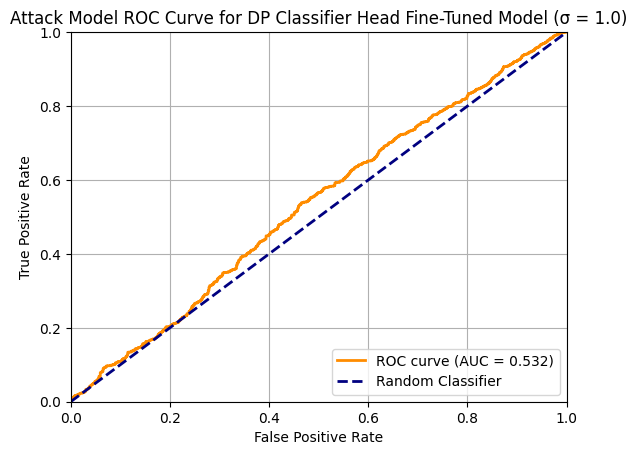

np.float64(0.5318694026840223)

In [ ]:
plot_roc_curve(attack_dp_y_prob, attack_dp_y, noise_scale=1.0)


#### Non-Private Baseline

In [ ]:
final_base_model_path = 'attack_results_noDP/final_models/final_model_10_30_50.0_20250625.pth'
final_base_scaler_path = 'attack_results_noDP/final_models/final_scaler_10_30_50.0_20250625.pkl'
final_base_label_encoder_path = 'attack_results_noDP/final_models/final_label_encoder_10_30_50.0_20250625.pkl'

BATCH_SIZE = 32

final_scaler_base = pickle.load(open(final_base_scaler_path, 'rb'))
final_le_base = pickle.load(open(final_base_label_encoder_path, 'rb'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# True Members
final_base_model = copy.deepcopy(original_model)
base_state_dict = torch.load(final_base_model_path, weights_only=True, map_location='cpu')
final_base_model.load_state_dict(remove_module_prefix(base_state_dict))
final_base_model.to(device)

scaled_target_model_X = final_scaler_base.transform(Target_Model_X)
encoded_target_model_y = final_le_base.transform(Target_Model_y)        # just adding to complete data loader. It doesn't matter.
train_data_loader_member_base = get_data_loader(scaled_target_model_X, encoded_target_model_y, BATCH_SIZE=BATCH_SIZE, shuffle=False)
base_probs_base = predict_proba(final_base_model, train_data_loader_member_base, device)
base_probs_base = np.array(base_probs_base)

true_members = np.ones((len(Target_Model_X),))

# True Non-Members
scaled_shadow_model_X = final_scaler_base.transform(Shadow_Model_X)
encoded_shadow_model_y = final_le_base.transform(Shadow_Model_y)      # just adding to complete data loader. It doesn't matter.
train_data_loader_non_member_base = get_data_loader(scaled_shadow_model_X, encoded_shadow_model_y, BATCH_SIZE=BATCH_SIZE, shuffle=False)
base_probs_base_non_members = predict_proba(final_dp_model, train_data_loader_non_member_base, device)
base_probs_base_non_members = np.array(dp_probs_dp_non_members)

true_non_members = np.zeros((len(Shadow_Model_X),))


true_members_set = np.concatenate([base_probs_base, true_members.reshape(-1, 1)], axis=1)
true_non_members_set = np.concatenate([base_probs_base_non_members, true_non_members.reshape(-1, 1)], axis=1)

true_set_base = np.concatenate([true_members_set, true_non_members_set])
np.random.shuffle(true_set_base)

true_base_df = pd.DataFrame(true_set_base)


#### Attack Model Preds on Non-Private (no DP)

In [ ]:
attack_base_X = true_base_df.iloc[:, :-1].values
attack_base_y = true_base_df.iloc[:, -1].values

attack_base_y_pred = clf.predict(attack_base_X)
attack_base_y_prob = clf.predict_proba(attack_base_X)[:,1]  # for binary AUC

print("Test Accuracy for DP-SGD:  ", accuracy_score(attack_base_y, attack_base_y_pred))
print("Test ROC AUC for DP-SGD:   ", roc_auc_score(attack_base_y, attack_base_y_prob))
print("\nClassification Report for DP-SGD:\n", classification_report(attack_base_y, attack_base_y_pred))

Test Accuracy for DP-SGD:   0.46414963630065814
Test ROC AUC for DP-SGD:    0.6896002141275519

Classification Report for DP-SGD:
               precision    recall  f1-score   support

         0.0       0.31      0.91      0.46       721
         1.0       0.91      0.32      0.47      2166

    accuracy                           0.46      2887
   macro avg       0.61      0.61      0.46      2887
weighted avg       0.76      0.46      0.47      2887



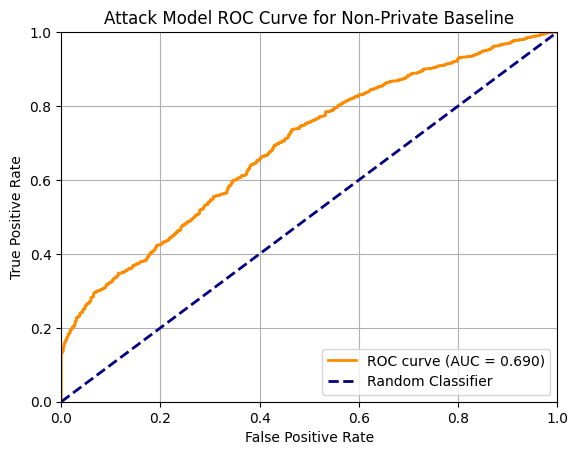

np.float64(0.6896002141275519)

In [ ]:
plot_roc_curve(attack_base_y_prob, attack_base_y)